# Titanic 3<br/>*Modeling Data with Groups*

Jupyter Notebook referenced from my website:
[Software Nirvana: Titantic 3](https://sdiehl28.netlify.com/2018/03/titanic-3/)

### Where We Are
In the second iteration we created a simple model that discarded all non-numeric variables and imputed missing Age values.

### What's Next
This notebook will focus on using the SQL equivalent of "group by" or the statistical equivalent of "conditioned on".  Often subsets of the data, partitioned by certain values of the variables, show a pattern.

Additionaly this notebook will show how to create a custom Transformer in order to properly use the custom imputation.

<a name="outline"></a>
### Outline
1. [Previous Iteration](#previous)
2. [Exploratory Data Analysis](#eda)
3. [Preprocessing](#preprocess)
4. [Model Building](#model)
5. [Model Evaluation](#eval)
6. [Summary](#summary)

### Common Imports and Notebook Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
%matplotlib inline
sns.set() # enable seaborn style

<a name="previous"></a>
### Previous Iteration
[Back to Outline](#outline)

In [2]:
# read in all the labeled data
all_data = pd.read_csv('../data/train.csv')

# break up the dataframe into X and y
X = all_data.drop('Survived', axis=1)
y = all_data['Survived']

# Remove PassengerId and all non-numeric fields except Sex
drop_cols = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'Embarked']
X = X.drop(drop_cols, axis=1)
X.dtypes

Pclass      int64
Sex        object
Age       float64
SibSp       int64
Parch       int64
Fare      float64
dtype: object

In [3]:
all_data.shape

(891, 12)

<a name="eda"></a>
### Exploratory Data Analysis
[Back to Outline](#outline)

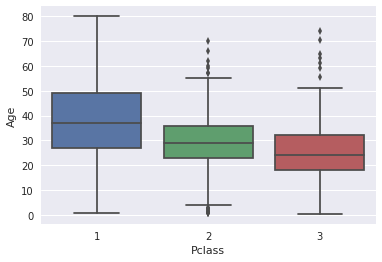

In [4]:
sns.boxplot(x='Pclass', y='Age', data=X)

We see that there is a clear releationship between age and passenger class.

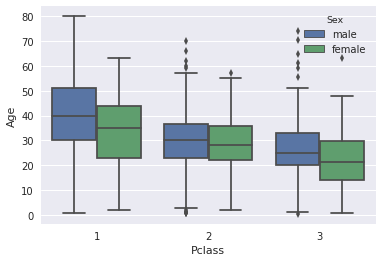

In [5]:
sns.boxplot(x='Pclass', y='Age', hue='Sex', data=X)

We see that for each passenger class, females are younger than males.  One way to impute missing age values then is to use replace the missing age value with the average age in each of the above 6 groups.

### Avoiding Data Leakage

**Cross Validation the Wrong Way**  
As discussed in the previous notebook, we cannot use the entire data set in order to impute age.  If we don't separate out the train data from the test data, then by definition the test data has "leaked" into the train data.

There are many tutorials for Titanic which impute age based on passenger class and gender, but I have yet to see one that uses cross validation correctly.  This is in part because it is difficult (i.e. time consuming) to explain how to do it correctly, and for this *particular* dataset, the estimated accuracy doing this correctly vs incorrectly is very close to the same.

What I would like to show here is how to transform data *correctly*.  The Titanic dataset is used for concreteness, but it is not representative of all datasets.  Understanding how to transform data, and use cross validation correctly, is essential to any real-world problem.

First, let's impute age and use cross validation the easy, and *wrong* way.  This is instructive because its sets the stage for how to do it correctly.

In [6]:
print('Number of observations: ', len(X))
print('Number of Null Age Values: ', X['Age'].isnull().sum())

Number of observations:  891
Number of Null Age Values:  177


In [7]:
# Write a function that imputes mean
def impute_mean(series):
    return series.fillna(series.mean())

imputed_age_values = X.groupby(['Pclass', 'Sex'])['Age'].apply(impute_mean)
print('Number of observations: ', len(imputed_age_values))
print('Number of Null Age Values after imputing: ', imputed_age_values.isnull().sum())

Number of observations:  891
Number of Null Age Values after imputing:  0


There were 177 null age values and now there are 0, so the above code, at the very least, did replace null values.

### Pandas GroupBy
Although we will not use apply() when we perform cross validation correctly, groupby() and apply() are very powerful Pandas methods and it is worthwhile to discuss them further.  groupby() is directly equivalent to SQL's "group by" clause.

In [8]:
by_pclass_sex = X.groupby(['Pclass', 'Sex'])
print(type(by_pclass_sex))
print(type(by_pclass_sex['Age']))

<class 'pandas.core.groupby.DataFrameGroupBy'>
<class 'pandas.core.groupby.SeriesGroupBy'>


In [9]:
# Number of records in each group
by_pclass_sex.size()

Pclass  Sex   
1       female     94
        male      122
2       female     76
        male      108
3       female    144
        male      347
dtype: int64

In [10]:
# Mean value of Age in each group
# This syntax only works for a few aggregate functions, such as mean and sum
by_pclass_sex['Age'].mean()

Pclass  Sex   
1       female    34.611765
        male      41.281386
2       female    28.722973
        male      30.740707
3       female    21.750000
        male      26.507589
Name: Age, dtype: float64

In [11]:
# Equivalent
# This syntax works for all numpy universal functions
mean_age_by_pclass_sex = by_pclass_sex['Age'].apply(np.mean)
mean_age_by_pclass_sex

Pclass  Sex   
1       female    34.611765
        male      41.281386
2       female    28.722973
        male      30.740707
3       female    21.750000
        male      26.507589
Name: Age, dtype: float64

In [100]:
a = pd.DataFrame(mean_age_by_pclass_sex)
a

Age
Pclass Sex              
1      female  34.611765
       male    41.281386
2      female  28.722973
       male    30.740707
3      female  21.750000
       male    26.507589

In [64]:
a.loc[(idx[:],'male'), :].values

array([[41.28138614],
       [30.74070707],
       [26.50758893]])

In [63]:
idx = pd.IndexSlice
mean_age_by_pclass_sex.loc[(idx[:],'male')].values

array([41.28138614, 30.74070707, 26.50758893])

In [52]:
a.loc[pd.IndexSlice[:],'male', :].values

KeyError: 'the label [male] is not in the [columns]'

In [65]:
mean_age_by_pclass_sex.loc[([1,2], 'female')]

Pclass  Sex   
1       female    34.611765
2       female    28.722973
Name: Age, dtype: float64

In [71]:
a.loc[([1,2], ['female', 'male']), 'Age']

Pclass  Sex   
1       female    34.611765
        male      41.281386
2       female    28.722973
        male      30.740707
Name: Age, dtype: float64

In [72]:
a.loc[([(1, 'female'), (2, 'female'), (1, 'male')]), 'Age']

Pclass  Sex   
1       female    34.611765
2       female    28.722973
1       male      41.281386
Name: Age, dtype: float64

In [97]:
a = 2
b = 'female'
def f(X):
    print("hello")
    return X
    # return mean_age_by_pclass_sex.loc[(X['Pclass'],X['Sex'])]


In [102]:
a.index

MultiIndex(levels=[[1, 2, 3], ['female', 'male']],
           labels=[[0, 0, 1, 1, 2, 2], [0, 1, 0, 1, 0, 1]],
           names=['Pclass', 'Sex'])

In [103]:
a.reset_index(['Pclass', 'Sex'])

,Pclass,Sex,Age
0,1,female,34.611765
1,1,male,41.281386
2,2,female,28.722973
3,2,male,30.740707
4,3,female,21.750000
5,3,male,26.507589


In [123]:
X.loc[X['Age'].isnull(), ['Pclass', 'Sex']].join(mean_age_by_pclass_sex, 
                                                 on=['Pclass', 'Sex']).head()

,Pclass,Sex,Age
5,3,male,26.507589
17,2,male,30.740707
19,3,female,21.750000
26,3,male,26.507589
28,3,female,21.750000


In [124]:
X.loc[X['Age'].isnull(), ['Pclass', 'Sex']].join(a, 
                                                 on=['Pclass', 'Sex']).head()

,Pclass,Sex,Age
5,3,male,26.507589
17,2,male,30.740707
19,3,female,21.750000
26,3,male,26.507589
28,3,female,21.750000


In [128]:
X.loc[X['Age'].isnull(), ['Pclass', 'Sex']].join(mean_age_by_pclass_sex, 
                                                 on=['Pclass', 'Sex'])

,Pclass,Sex,Age
5,3,male,26.507589
17,2,male,30.740707
19,3,female,21.750000
26,3,male,26.507589
28,3,female,21.750000
29,3,male,26.507589
31,1,female,34.611765
32,3,female,21.750000
36,3,male,26.507589
42,3,male,26.507589


In [136]:
X.pivot_table('Age', index='Sex', columns='Pclass', aggfunc='mean')

Pclass,1,2,3
Sex,,,
female,34.611765,28.722973,21.750000
male,41.281386,30.740707,26.507589


In [137]:
pt = X.pivot_table('Age', index=['Pclass','Sex'], aggfunc='mean')
pt

Age
Pclass Sex              
1      female  34.611765
       male    41.281386
2      female  28.722973
       male    30.740707
3      female  21.750000
       male    26.507589

In [134]:
pt.loc[[(1, 'male'),(3,'female')]]

,,Age
Pclass,Sex,
1,male,41.281386
3,female,21.750000


In [12]:
# Note: Pandas created a hierarchical 2-part index for this groupby Series
by_pclass_sex['Age'].apply(np.mean).index

MultiIndex(levels=[[1, 2, 3], ['female', 'male']],
           labels=[[0, 0, 1, 1, 2, 2], [0, 1, 0, 1, 0, 1]],
           names=['Pclass', 'Sex'])

### Verify Code

In [13]:
# Look at first 6 records of original data
X[['Pclass', 'Sex', 'Age']].head(6)

,Pclass,Sex,Age
0,3,male,22.0
1,1,female,38.0
2,3,female,26.0
3,1,female,35.0
4,3,male,35.0
5,3,male,NaN


If the above code works correctly, then the first 5 Age values will remain unchanged and the 6th Age value will be replaced by the mean age in the group for Pclass=3 and Sex=male.

Above we saw that the mean age for that group was 26.507589.

In [14]:
# Check the results computed above
imputed_age_values.head(6)

0    22.000000
1    38.000000
2    26.000000
3    35.000000
4    35.000000
5    26.507589
Name: Age, dtype: float64

This is the result we wanted.  As a reminder, these values were computed by:
```python
def impute_mean(series):
    return series.fillna(series.mean())

imputed_age_values = X.groupby(['Pclass', 'Sex'])['Age'].apply(impute_mean)
```  
How this works:
- Taking the 'Age' column of the groupby produced a pandas.core.groupby.SeriesGroupBy.  
- apply() then passed each group of the 'Age' series to the impute_mean() method.  
- There are 6 groups, so impute_mean was called 6 times.  
- Each time it was called, it found the NA values in that group and replaced it with the mean Age value in that group.

### Scikit Learn Custom Transformer
Warning: This topic is not easy and is usually not discussed in beginning tutorials.  It is discussed here because developing good workflow habits that eliminate data leakage is important.

Again, we don't want to impute all missing values for the entire dataset at once, as this is "data leakage". However we do want to perform almost exactly the same steps as above.  The difference is that we want the mean Age value per group in the train data, to replace the missing values in the test data.

This means we need to save the grouped mean values computed in the train set and use those for the test set.  This fits the following paradigm:
- imputer = Imputer(strategy='mean')
- imputer.fit(trainData) will look at train data to find mean values
- imputer.transform(testData) will apply the train mean values to the missing test set values

We want a  imputer that uses group averages, not overall averages.  Scikit Learn does not have this so we will have to build our own custom Transformer.  It will have the same method signatures as above.

Ideally the custom transformer will operate on a Series or an array of values at once, as vectorized operations are often faster than looping over each record.

### fit() psuedo code
```python
train_by_pclass_sex = X_train.groupby(['Pclass', 'Sex'])
```

### transform() psuedo code
```python
# find the missing Age values in test
test_age_missing_idx =X_test['Age'].isnull()

# create a list of tuples for fancy indexing into 2-part index
idx_tuples = list(zip(X_test.loc[test_age_missing_idx, 'Pclass'],
                      X_test.loc[test_age_missing_idx, 'Sex']))

# compute mean of Age for each of the  groups
mean_age_by_pclass_sex = by_pclass_sex['Age'].mean()

# use train_by_pclass_sex as a lookup table whose key is the 2-part tuple above
test_imputed_age_values = mean_age_by_pclass_sex.loc[idx_tuples].values

# replace the missing Age values with the imputed age values
X_test.loc[test_age_missing_idx, 'Age'] = test_imputed_age_values
```

### Code Quality
For complicated tasks, it is helpful to write code snippets in two different but equivalent ways.  If the result is the same for both, it is likely that the code is working properly.

Use the above psuedo code to impute the missing Age values on the *entire* dataset, as was done above using apply.

In [19]:
# The following code will be abstracted out into a method of
# a custom Tranformer class.  For now, verify it works as intended.

# group by
by_pclass_sex = X.groupby(['Pclass', 'Sex'])

# missing indexes
age_missing_idx =X['Age'].isnull()

# tuple of 2 values to use as a key into the groupby age mean
idx_tuples = list(zip(X.loc[age_missing_idx, 'Pclass'],
                      X.loc[age_missing_idx, 'Sex']))

# group by age mean (will be used as a "lookup table")
mean_age_by_pclass_sex = by_pclass_sex['Age'].mean()

# lookup values
imputed_age_values_by_group = mean_age_by_pclass_sex.loc[idx_tuples].values

# get a copy of the data
X_copy = X.copy()

# replace the missing values with the imputed age values by group
X_copy.loc[age_missing_idx, 'Age'] = imputed_age_values_by_group

# get all the age values for comparison
imputed_age_values2 = X_copy['Age']

In [ ]:
# recompute the same values using Pandas groupby and apply
def impute_mean(series):
    return series.fillna(series.mean())

imputed_age_values = X.groupby(['Pclass', 'Sex'])['Age'].apply(impute_mean)

In [ ]:
# Check that the above code was equivalent to apply(impute_mean)
(imputed_age_values2.values == imputed_age_values.values).all()

### Custom Tranformer

In [ ]:
X.dtypes

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

In [ ]:
class MyTransformer(TransformerMixin):  

    # fit is applied to the train data
    def fit(self, X, y):
        self.mean_age_by_pclass_sex = X.groupby(['Pclass', 'Sex'])['Age'].mean()
        print(self.mean_age_by_pclass_sex)
        return self
    
    # transform is applied to the test data
    def transform(self, X):
        
        # find missing indexes
        age_missing_idx =X['Age'].isnull()
        
        # tuple of 2 values to use as a key into the groupby age mean
        idx_tuples = list(zip(X.loc[age_missing_idx, 'Pclass'],
                              X.loc[age_missing_idx, 'Sex']))
        
        # lookup values
        imputed_age_values_by_group = mean_age_by_pclass_sex.loc[idx_tuples].values
        
        # replace the missing values with the imputed age values by group
        X_copy = X.copy()
        X_copy.loc[age_missing_idx, 'Age'] = imputed_age_values_by_group
        X = X_copy

        return self

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import make_pipeline

classifier = make_pipeline(MyTransformer(), Debug(), LogisticRegression())

# cross_val_score() will properly compute 
# custom imputation and score per fold
scores = cross_val_score(classifier, X, y, cv=5, 
                         scoring='accuracy', n_jobs=1)

In [ ]:
class Debug(BaseEstimator, TransformerMixin):

    def transform(self, X):
        print(pd.DataFrame(X).head())
        print(X.shape)
        X = X.drop('Sex', axis=1)
        return X

    def fit(self, X, y=None, **fit_params):
        return self

# Good Up to Here
***

In [ ]:
# bool series, True where age is null
age_missing_idx = X['Age'].isnull()

# create a list of tuples for fancy indexing
idx_tuples = list(zip(X.loc[age_missing_idx, 'Pclass'],
                      X.loc[age_missing_idx, 'Sex']))

# lookup the mean value using the list of tuples as indexes 
# into mean_age_by_pclass_sex
imputed_age_values = mean_age_by_pclass_sex.loc[idx_tuples].values

In [ ]:
X.loc[age_missing_idx, 'Age'].head()

In [ ]:
X.loc[age_missing_idx, 'Age'] = imputed_age_values

In [ ]:
X.head(7)

In [ ]:
rng = np.random.RandomState(0)
df = pd.DataFrame({'key': ['A', 'B', 'C', 'A', 'B', 'C', 'A', 'B', 'C'],
                   'key2': ['A', 'B', 'C', 'A', 'B', 'C', 'A', 'B', 'C'],
                   'data1': range(9),
                   'data2': rng.randint(0, 10, 9)},
                  columns = ['key', 'key2', 'data1', 'data2'])
df

In [ ]:
df.iloc[2, 2] = np.NaN
df

In [ ]:
df.groupby('key').mean()

In [ ]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import TransformerMixin

In [ ]:
class ModelTransformer(TransformerMixin):

    def __init__(self, model):
        self.model = model

    def fit(self, *args, **kwargs):
        self.model.fit(*args, **kwargs)
        return self

    def transform(self, X, **transform_params):
        return DataFrame(self.model.predict(X))

In [ ]:
class MyTransformer(TransformerMixin):  
    
    def impute_mean(series):
        return series.fillna(series.mean())

    def fit(self, X):
        self.by_pclass_sex = X.groupby(['Pclass', 'Sex'])
        return self
    
    def transform(self, X):
        self.by_pclass_sex['Age'].apply(impute_mean)
        return self
        

In [ ]:
t = MyTransformer()
t.fit(X.head(10))
# t.transform(X.tail(10))

In [ ]:
X.head(10)

In [ ]:
t.transform(X.head(10))

In [ ]:
t.by_pclass_sex.mean()

In [ ]:
# From DataCamp 
# https://campus.datacamp.com/courses/manipulating-dataframes-with-pandas/grouping-data?ex=11

# Create a groupby object: by_sex_class
by_sex_class = X.groupby(['Sex','Pclass'])

# Write a function that imputes median
def impute_mean(series):
    return series.fillna(series.mean())

# Impute age and assign to titanic['age']
by_sex_class['Age'].apply(impute_mean).head(10)

In [ ]:
X['Age'][X['Age'].isnull()].head()

In [ ]:
result.loc[[1,2,1],:]

In [ ]:
result.loc[[1,1], 'female']

In [ ]:
result.loc[:, X['Sex']]

In [ ]:
random_state = 100
n_splits = 5

# create K=n_splits folds
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, KFold
crossvalidation = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

In [ ]:
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy='mean')

from sklearn.pipeline import make_pipeline
classifier = make_pipeline(imputer, LogisticRegression())

# use cross_val_score() to properly compute the imputation and score per fold
scores = cross_val_score(classifier, X, y, cv=crossvalidation, scoring='accuracy',
 n_jobs=1)

### Impute Age Value
For instructional purposes, to emphasize not looking at the test data, this this will be performed manually rather than using a Scikit Learn Imputer.

In [ ]:
# Get a boolean Series where Age is null
train_age_null = X_train['Age'].isnull()

In [ ]:
# Verify we did this correctly
X_train.loc[train_age_null, 'Age'].head()

In [ ]:
# Train dataset will be used to train model
# Set the null Age values, in train, to the mean Age value, in train
X_train.loc[train_age_null, 'Age'] = X_train['Age'].mean()

In [ ]:
# Observe the mean value
X_train['Age'].mean()

In [ ]:
# double check that the values that were null are now the mean
X_train.loc[train_age_null, 'Age'].head()

### Replace Test Set Null Age Values with Mean from *Train* Set
This step is key to understanding how to avoid "test set data leakage".  If we look at the data in the test set, in any way, it no longer acts as a test set.

We must replace null values in the test set with the mean from the *train* set without looking at any of the values in the *test* set.

In [ ]:
# Test dataset will be used to evaluate the model's accuracy
# Set the null Age values, in test, to the mean Age value, in train
test_age_null = X_test['Age'].isnull()
X_test.loc[test_age_null, 'Age'] = X_train['Age'].mean()

In [ ]:
# double check that the values that were null are now the mean
X_test.loc[test_age_null, 'Age'].head()

### Summary of Imputation
It is critical to understand that we replaced null values in the test set with values computed from the train set.  We never looked at the data in test set

Although we did not use Scikit Learn's imputer, when used properly, it also uses data from the train set to transform the test set.

### Examine Datatypes
This cell was copied from the 1st iteration.  In this notebook we are not going to address datatypes, but keep this note as a reminder (or put it in an issue tracking system).

Based on a review of the data dictionary at [titanic](https://www.kaggle.com/c/titanic/data), and an examination of the values of each column, the following variables need to be converted to categorical:

**Next Iteration: convert the following variables to categorical**
- Pclass
- Sex
- Embarked


In [ ]:
# For 2nd Iteration only, ignore all text and categorical variables
X_train = X_train.drop('Pclass', axis=1)
X_test = X_test.drop('Pclass', axis=1)
X_train = X_train.drop('Name', axis=1)
X_test = X_test.drop('Name', axis=1)
X_train = X_train.drop('Sex', axis=1)
X_test = X_test.drop('Sex', axis=1)
X_train = X_train.drop('Ticket', axis=1)
X_test = X_test.drop('Ticket', axis=1)
X_train = X_train.drop('Embarked', axis=1)
X_test = X_test.drop('Embarked', axis=1)
X_train = X_train.drop('Cabin', axis=1)
X_test = X_test.drop('Cabin', axis=1)

A natural question to ask is, wouldn't it have been easier to drop these columns prior
to creating the train/test split so we wouldn't have to apply the same operation (drop column) to one?  The answer is "yes", but the proper way to do this, while ensuring no "test data leakage", is by way of pipelines and that will be discussed in a subsequent notebook.

In [ ]:
# Examine the datatypes of each remaining column
X_train.dtypes

<a name="preprocess"></a>
### Preprocessing
[Back to Outline](#outline)

Preprocessing was done "inline" with the Exploratory Data Analysis above.

<a name="model"></a>
### Model Building
[Back to Outline](#outline)

In [ ]:
# Build Model
from sklearn.linear_model import LogisticRegression
base_model = LogisticRegression()
base_model.fit(X_train, y_train)

<a name="eval"></a>
### Model Evaluation
[Back to Outline](#outline)

In [ ]:
predictions = base_model.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(predictions, y_test)

In [ ]:
# Compute Accuracy
base_model_accuracy = (155 + 28) / (155+69+16+28)
print(base_model_accuracy)

68.2% is about the same as the previous iteration of 67.9%.  The difference is probably not statistically significant, but the aim for this notebook was to show how to perform preprocessing without looking at the test data set.

<a name="summary"></a>
### Conclusion
[Back to Outline](#outline)

In this iteration:
* we showed an example of preprocessing without looking at the test set
* measured an accuracy of 68.2% which is 
* noted a few things to try to improve the model
* established a baseline accuracy of 68%
* showed that this accuracy is better than the null model accuracy of 64%